In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/2.2_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/2.2_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-LOCA':1,
              'I-TIME':2,
              'I-GEOUN':3,
              'I-GEOSTR':4
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/2.2_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 68:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 68))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 2548 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            68,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(8, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 68)            173332    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 16)            4928      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 5)             85        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 5)             65        
Total params: 178,410
Trainable params: 5,078
Non-trainable params: 173,332
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 2118 samples, validate on 236 samples
Epoch 1/1000
2118/2118 [==============================] - 3s 1ms/step - loss: 2.5835 - crf_viterbi_accuracy: 0.8007 - val_loss: 2.7212 - val_crf_viterbi_accuracy: 0.7793
Epoch 2/1000
2118/2118 [==============================] - 1s 580us/step - loss: 2.3994 - crf_viterbi_accuracy: 0.8448 - val_loss: 2.6705 - val_crf_viterbi_accuracy: 0.7793
Epoch 3/1000
2118/2118 [==============================] - 1s 589us/step - loss: 2.3607 - crf_viterbi_accuracy: 0.8452 - val_loss: 2.6200 - val_crf_viterbi_accuracy: 0.7793
Epoch 4/1000
2118/2118 [==============================] - 1s 571us/step - loss: 2.3352 - crf_viterbi_accuracy: 0.8455 - val_loss: 2.5894 - val_crf_viterbi_accuracy: 0.7793
Epoch 5/1000
2118/2118 [==============================] - 1s 585us/step - loss: 2.3195 - crf_viterbi_accuracy: 0.8459 - val_loss: 2.5628 - val_crf_viterbi_accuracy: 0.7793
Epoch 6/1000
2118/2118 [==============================] - 1s 575us/step - loss: 2.3045 - crf_

Epoch 46/1000
2118/2118 [==============================] - 1s 601us/step - loss: 2.1264 - crf_viterbi_accuracy: 0.8605 - val_loss: 2.2248 - val_crf_viterbi_accuracy: 0.8401
Epoch 47/1000
2118/2118 [==============================] - 1s 593us/step - loss: 2.1234 - crf_viterbi_accuracy: 0.8605 - val_loss: 2.2209 - val_crf_viterbi_accuracy: 0.8440
Epoch 48/1000
2118/2118 [==============================] - 1s 564us/step - loss: 2.1228 - crf_viterbi_accuracy: 0.8622 - val_loss: 2.2185 - val_crf_viterbi_accuracy: 0.8440
Epoch 49/1000
2118/2118 [==============================] - 1s 561us/step - loss: 2.1223 - crf_viterbi_accuracy: 0.8609 - val_loss: 2.2150 - val_crf_viterbi_accuracy: 0.8440
Epoch 50/1000
2118/2118 [==============================] - 1s 572us/step - loss: 2.1206 - crf_viterbi_accuracy: 0.8607 - val_loss: 2.2114 - val_crf_viterbi_accuracy: 0.8440
Epoch 51/1000
2118/2118 [==============================] - 1s 575us/step - loss: 2.1184 - crf_viterbi_accuracy: 0.8616 - val_loss: 2.20

2118/2118 [==============================] - 1s 564us/step - loss: 2.0232 - crf_viterbi_accuracy: 0.8869 - val_loss: 2.0765 - val_crf_viterbi_accuracy: 0.9009
Epoch 141/1000
2118/2118 [==============================] - 1s 561us/step - loss: 2.0216 - crf_viterbi_accuracy: 0.8877 - val_loss: 2.0760 - val_crf_viterbi_accuracy: 0.9009
Epoch 142/1000
2118/2118 [==============================] - 1s 593us/step - loss: 2.0176 - crf_viterbi_accuracy: 0.8890 - val_loss: 2.0742 - val_crf_viterbi_accuracy: 0.9044
Epoch 143/1000
2118/2118 [==============================] - 1s 569us/step - loss: 2.0184 - crf_viterbi_accuracy: 0.8883 - val_loss: 2.0740 - val_crf_viterbi_accuracy: 0.9032
Epoch 144/1000
2118/2118 [==============================] - 1s 618us/step - loss: 2.0171 - crf_viterbi_accuracy: 0.8889 - val_loss: 2.0725 - val_crf_viterbi_accuracy: 0.9044
Epoch 145/1000
2118/2118 [==============================] - 1s 594us/step - loss: 2.0173 - crf_viterbi_accuracy: 0.8899 - val_loss: 2.0732 - val_

2118/2118 [==============================] - 1s 630us/step - loss: 1.9784 - crf_viterbi_accuracy: 0.9010 - val_loss: 2.0230 - val_crf_viterbi_accuracy: 0.9365
Epoch 235/1000
2118/2118 [==============================] - 1s 656us/step - loss: 1.9765 - crf_viterbi_accuracy: 0.9001 - val_loss: 2.0225 - val_crf_viterbi_accuracy: 0.9336
Epoch 236/1000
2118/2118 [==============================] - 1s 616us/step - loss: 1.9780 - crf_viterbi_accuracy: 0.9016 - val_loss: 2.0220 - val_crf_viterbi_accuracy: 0.9365
Epoch 237/1000
2118/2118 [==============================] - 1s 652us/step - loss: 1.9743 - crf_viterbi_accuracy: 0.9031 - val_loss: 2.0218 - val_crf_viterbi_accuracy: 0.9365
Epoch 238/1000
2118/2118 [==============================] - 1s 639us/step - loss: 1.9764 - crf_viterbi_accuracy: 0.9031 - val_loss: 2.0216 - val_crf_viterbi_accuracy: 0.9355
Epoch 239/1000
2118/2118 [==============================] - 1s 620us/step - loss: 1.9765 - crf_viterbi_accuracy: 0.9009 - val_loss: 2.0214 - val_

2118/2118 [==============================] - 1s 598us/step - loss: 1.9527 - crf_viterbi_accuracy: 0.9103 - val_loss: 1.9940 - val_crf_viterbi_accuracy: 0.9494
Epoch 329/1000
2118/2118 [==============================] - 1s 610us/step - loss: 1.9554 - crf_viterbi_accuracy: 0.9104 - val_loss: 1.9937 - val_crf_viterbi_accuracy: 0.9517
Epoch 330/1000
2118/2118 [==============================] - 1s 630us/step - loss: 1.9545 - crf_viterbi_accuracy: 0.9097 - val_loss: 1.9936 - val_crf_viterbi_accuracy: 0.9517
Epoch 331/1000
2118/2118 [==============================] - 1s 609us/step - loss: 1.9552 - crf_viterbi_accuracy: 0.9090 - val_loss: 1.9932 - val_crf_viterbi_accuracy: 0.9517
Epoch 332/1000
2118/2118 [==============================] - 1s 627us/step - loss: 1.9512 - crf_viterbi_accuracy: 0.9111 - val_loss: 1.9931 - val_crf_viterbi_accuracy: 0.9507
Epoch 333/1000
2118/2118 [==============================] - 1s 602us/step - loss: 1.9512 - crf_viterbi_accuracy: 0.9125 - val_loss: 1.9930 - val_

2118/2118 [==============================] - 1s 620us/step - loss: 1.9359 - crf_viterbi_accuracy: 0.9160 - val_loss: 1.9749 - val_crf_viterbi_accuracy: 0.9620
Epoch 423/1000
2118/2118 [==============================] - 1s 640us/step - loss: 1.9381 - crf_viterbi_accuracy: 0.9155 - val_loss: 1.9747 - val_crf_viterbi_accuracy: 0.9620
Epoch 424/1000
2118/2118 [==============================] - 1s 634us/step - loss: 1.9344 - crf_viterbi_accuracy: 0.9176 - val_loss: 1.9746 - val_crf_viterbi_accuracy: 0.9620
Epoch 425/1000
2118/2118 [==============================] - 1s 609us/step - loss: 1.9389 - crf_viterbi_accuracy: 0.9151 - val_loss: 1.9744 - val_crf_viterbi_accuracy: 0.9620
Epoch 426/1000
2118/2118 [==============================] - 1s 594us/step - loss: 1.9387 - crf_viterbi_accuracy: 0.9147 - val_loss: 1.9743 - val_crf_viterbi_accuracy: 0.9630
Epoch 427/1000
2118/2118 [==============================] - 1s 613us/step - loss: 1.9383 - crf_viterbi_accuracy: 0.9161 - val_loss: 1.9742 - val_

2118/2118 [==============================] - 1s 576us/step - loss: 1.9265 - crf_viterbi_accuracy: 0.9192 - val_loss: 1.9613 - val_crf_viterbi_accuracy: 0.9681
Epoch 517/1000
2118/2118 [==============================] - 1s 591us/step - loss: 1.9260 - crf_viterbi_accuracy: 0.9198 - val_loss: 1.9614 - val_crf_viterbi_accuracy: 0.9671
Epoch 518/1000
2118/2118 [==============================] - 1s 617us/step - loss: 1.9253 - crf_viterbi_accuracy: 0.9188 - val_loss: 1.9612 - val_crf_viterbi_accuracy: 0.9671
Epoch 519/1000
2118/2118 [==============================] - 1s 612us/step - loss: 1.9276 - crf_viterbi_accuracy: 0.9175 - val_loss: 1.9610 - val_crf_viterbi_accuracy: 0.9681
Epoch 520/1000
2118/2118 [==============================] - 1s 610us/step - loss: 1.9258 - crf_viterbi_accuracy: 0.9177 - val_loss: 1.9609 - val_crf_viterbi_accuracy: 0.9681
Epoch 521/1000
2118/2118 [==============================] - 1s 643us/step - loss: 1.9267 - crf_viterbi_accuracy: 0.9196 - val_loss: 1.9610 - val_

2118/2118 [==============================] - 1s 563us/step - loss: 1.9191 - crf_viterbi_accuracy: 0.9226 - val_loss: 1.9521 - val_crf_viterbi_accuracy: 0.9671
Epoch 611/1000
2118/2118 [==============================] - 1s 560us/step - loss: 1.9189 - crf_viterbi_accuracy: 0.9217 - val_loss: 1.9519 - val_crf_viterbi_accuracy: 0.9671
Epoch 612/1000
2118/2118 [==============================] - 1s 566us/step - loss: 1.9163 - crf_viterbi_accuracy: 0.9231 - val_loss: 1.9518 - val_crf_viterbi_accuracy: 0.9694
Epoch 613/1000
2118/2118 [==============================] - 1s 574us/step - loss: 1.9196 - crf_viterbi_accuracy: 0.9212 - val_loss: 1.9518 - val_crf_viterbi_accuracy: 0.9671
Epoch 614/1000
2118/2118 [==============================] - 1s 579us/step - loss: 1.9156 - crf_viterbi_accuracy: 0.9249 - val_loss: 1.9516 - val_crf_viterbi_accuracy: 0.9694
Epoch 615/1000
2118/2118 [==============================] - 1s 575us/step - loss: 1.9183 - crf_viterbi_accuracy: 0.9218 - val_loss: 1.9516 - val_

2118/2118 [==============================] - 1s 553us/step - loss: 1.9077 - crf_viterbi_accuracy: 0.9256 - val_loss: 1.9448 - val_crf_viterbi_accuracy: 0.9706
Epoch 705/1000
2118/2118 [==============================] - 1s 551us/step - loss: 1.9108 - crf_viterbi_accuracy: 0.9260 - val_loss: 1.9448 - val_crf_viterbi_accuracy: 0.9706
Epoch 706/1000
2118/2118 [==============================] - 1s 542us/step - loss: 1.9117 - crf_viterbi_accuracy: 0.9255 - val_loss: 1.9449 - val_crf_viterbi_accuracy: 0.9706
Epoch 707/1000
2118/2118 [==============================] - 1s 546us/step - loss: 1.9093 - crf_viterbi_accuracy: 0.9262 - val_loss: 1.9448 - val_crf_viterbi_accuracy: 0.9706
Epoch 708/1000
2118/2118 [==============================] - 1s 550us/step - loss: 1.9088 - crf_viterbi_accuracy: 0.9260 - val_loss: 1.9448 - val_crf_viterbi_accuracy: 0.9706
Epoch 709/1000
2118/2118 [==============================] - 1s 545us/step - loss: 1.9102 - crf_viterbi_accuracy: 0.9243 - val_loss: 1.9448 - val_

2118/2118 [==============================] - 1s 631us/step - loss: 1.9057 - crf_viterbi_accuracy: 0.9273 - val_loss: 1.9388 - val_crf_viterbi_accuracy: 0.9718
Epoch 799/1000
2118/2118 [==============================] - 1s 599us/step - loss: 1.9068 - crf_viterbi_accuracy: 0.9257 - val_loss: 1.9389 - val_crf_viterbi_accuracy: 0.9704
Epoch 800/1000
2118/2118 [==============================] - 1s 605us/step - loss: 1.9034 - crf_viterbi_accuracy: 0.9281 - val_loss: 1.9387 - val_crf_viterbi_accuracy: 0.9727
Epoch 801/1000
2118/2118 [==============================] - 1s 591us/step - loss: 1.9019 - crf_viterbi_accuracy: 0.9283 - val_loss: 1.9385 - val_crf_viterbi_accuracy: 0.9718
Epoch 802/1000
2118/2118 [==============================] - 1s 587us/step - loss: 1.9022 - crf_viterbi_accuracy: 0.9289 - val_loss: 1.9384 - val_crf_viterbi_accuracy: 0.9727
Epoch 803/1000
2118/2118 [==============================] - 1s 578us/step - loss: 1.9048 - crf_viterbi_accuracy: 0.9264 - val_loss: 1.9384 - val_

2118/2118 [==============================] - 1s 601us/step - loss: 1.8974 - crf_viterbi_accuracy: 0.9299 - val_loss: 1.9338 - val_crf_viterbi_accuracy: 0.9714
Epoch 893/1000
2118/2118 [==============================] - 1s 589us/step - loss: 1.8984 - crf_viterbi_accuracy: 0.9302 - val_loss: 1.9336 - val_crf_viterbi_accuracy: 0.9714
Epoch 894/1000
2118/2118 [==============================] - 1s 594us/step - loss: 1.8976 - crf_viterbi_accuracy: 0.9311 - val_loss: 1.9335 - val_crf_viterbi_accuracy: 0.9714
Epoch 895/1000
2118/2118 [==============================] - 1s 597us/step - loss: 1.8966 - crf_viterbi_accuracy: 0.9308 - val_loss: 1.9334 - val_crf_viterbi_accuracy: 0.9714
Epoch 896/1000
2118/2118 [==============================] - 1s 586us/step - loss: 1.8974 - crf_viterbi_accuracy: 0.9306 - val_loss: 1.9333 - val_crf_viterbi_accuracy: 0.9714
Epoch 897/1000
2118/2118 [==============================] - 1s 564us/step - loss: 1.8997 - crf_viterbi_accuracy: 0.9293 - val_loss: 1.9335 - val_

2118/2118 [==============================] - 1s 593us/step - loss: 1.8940 - crf_viterbi_accuracy: 0.9307 - val_loss: 1.9295 - val_crf_viterbi_accuracy: 0.9737
Epoch 987/1000
2118/2118 [==============================] - 1s 682us/step - loss: 1.8938 - crf_viterbi_accuracy: 0.9312 - val_loss: 1.9295 - val_crf_viterbi_accuracy: 0.9714
Epoch 988/1000
2118/2118 [==============================] - 1s 621us/step - loss: 1.8952 - crf_viterbi_accuracy: 0.9310 - val_loss: 1.9294 - val_crf_viterbi_accuracy: 0.9714
Epoch 989/1000
2118/2118 [==============================] - 1s 625us/step - loss: 1.8930 - crf_viterbi_accuracy: 0.9319 - val_loss: 1.9292 - val_crf_viterbi_accuracy: 0.9723
Epoch 990/1000
2118/2118 [==============================] - 1s 588us/step - loss: 1.8932 - crf_viterbi_accuracy: 0.9313 - val_loss: 1.9293 - val_crf_viterbi_accuracy: 0.9714
Epoch 991/1000
2118/2118 [==============================] - 1s 586us/step - loss: 1.8927 - crf_viterbi_accuracy: 0.9320 - val_loss: 1.9293 - val_

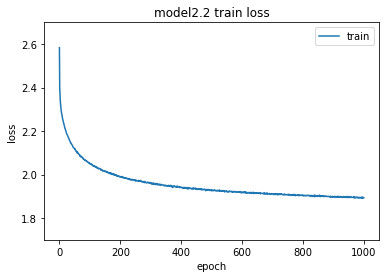

In [8]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model2.2 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([1.7,2.7])

In [11]:
model.save('/home/wcb/nerXY/model/model2.2.h5')